In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/game-recommendations-on-steam/games_metadata.json
/kaggle/input/game-recommendations-on-steam/users.csv
/kaggle/input/game-recommendations-on-steam/games.csv
/kaggle/input/game-recommendations-on-steam/recommendations.csv


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

__import__('warnings').filterwarnings("ignore")

params_plt = {'font.size': 14,
              'axes.titlesize': 15,  # Размер шрифта главной подписи
              'axes.labelsize': 14,  # Размер шрифта подписей осей
              'xtick.labelsize': 12,  # Размер шрифта подписей тикетов оси X
              'ytick.labelsize': 12,  # Размер шрифта подписей тикетов оси Y
              'figure.figsize': (18,10)
              }

plt.rcParams.update(params_plt)

In [3]:
def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :param use_float: преобразовывать float в пониженную размерность
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        # print(f'{col} тип: {tmp[col].dtype}', str(tmp[col].dtype)[:4])

        if str(df[col].dtype)[:4] in 'datetime':
            continue

        elif str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        elif use_category and str(df[col].dtype) == 'object':
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df

In [4]:
data = pd.read_csv('/kaggle/input/game-recommendations-on-steam/recommendations.csv')
games = pd.read_csv('/kaggle/input/game-recommendations-on-steam/games.csv')
metadata = pd.read_json('/kaggle/input/game-recommendations-on-steam/games_metadata.json', lines=True)

In [5]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d').dt.date
data = memory_compression(data)

Исходный размер датасета в памяти равен 2056.94 мб.
Конечный размер датасета в памяти равен 830.15 мб.
Экономия памяти = 59.6%


In [6]:
data.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.312500,49078,0
1,304390,4,0,2017-02-17,False,11.500000,2461,1
2,1085660,2,0,2019-11-17,True,336.500000,240559,2
3,703080,0,0,2022-09-23,True,27.406250,245798,3
4,526870,0,0,2021-01-10,True,7.898438,22629,4


In [7]:
# посмотрим на предмет выбросов
data[['helpful', 'funny', 'hours']].describe().round(1).fillna(0)

,helpful,funny,hours
count,37839599.0,37839599.0,37839599.0
mean,3.3,1.1,0.0
std,48.5,29.7,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,8.4
50%,0.0,0.0,29.1
75%,0.0,0.0,104.3
max,36212.0,28088.0,1000.0


In [8]:
# отфильтруем значения, которые больше 0.5% квантиля
columns = ['helpful', 'funny', 'hours']
quantiles_low = data[columns].quantile(0.005)
quantiles_high = data[columns].quantile(0.995)
quantiles_low, quantiles_high

(helpful    0.000000
 funny      0.000000
 hours      0.099976
 Name: 0.005, dtype: float64,
 helpful    100.0
 funny       32.0
 hours      931.5
 Name: 0.995, dtype: float64)

In [9]:
for col in columns:
    data = data[(quantiles_low[col] <= data[col]) & (data[col] < quantiles_high[col])]
    
data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37360382 entries, 0 to 37839598
Data columns (total 8 columns):
 #   Column          Dtype   
---  ------          -----   
 0   app_id          int32   
 1   helpful         int32   
 2   funny           int16   
 3   date            category
 4   is_recommended  bool    
 5   hours           float16 
 6   user_id         int32   
 7   review_id       int32   
dtypes: bool(1), category(1), float16(1), int16(1), int32(4)
memory usage: 1.1 GB


In [10]:
data[['helpful', 'funny', 'hours']].describe().round(1).fillna(0)

,helpful,funny,hours
count,37360382.0,37360382.0,37360382.0
mean,1.5,0.3,0.0
std,6.1,1.7,0.0
min,0.0,0.0,0.1
25%,0.0,0.0,8.3
50%,0.0,0.0,28.8
75%,0.0,0.0,101.9
max,99.0,31.0,931.0


#### БОльшая часть выбросов ушла

In [11]:
games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [12]:
metadata.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [13]:
df_grp = data.groupby(['app_id', 'is_recommended'], as_index=False).agg(
            hours_mean=('hours', 'mean'),
            hours_median=('hours', 'median'),
            users=('user_id', lambda x: x.nunique()),
        )

In [14]:
df_grp

,app_id,is_recommended,hours_mean,hours_median,users
0,10,False,108.937500,10.703125,1596
1,10,True,233.625000,110.812500,36006
2,20,False,7.738281,0.700195,565
3,20,True,37.531250,3.400391,3462
4,30,False,11.273438,0.500000,452
...,...,...,...,...,...
63289,2245890,True,1.257812,0.700195,7
63290,2251240,False,0.099976,0.099976,1
63291,2251240,True,0.699707,0.699707,2
63292,2253290,False,0.549805,0.549805,2


In [15]:
data.groupby('is_recommended').agg({'hours': ['median', 'mean', 'max']}).round(1)

hours                 
                   median      mean    max
is_recommended                            
False           11.703125   79.0000  931.0
True            31.906250  102.8125  931.0

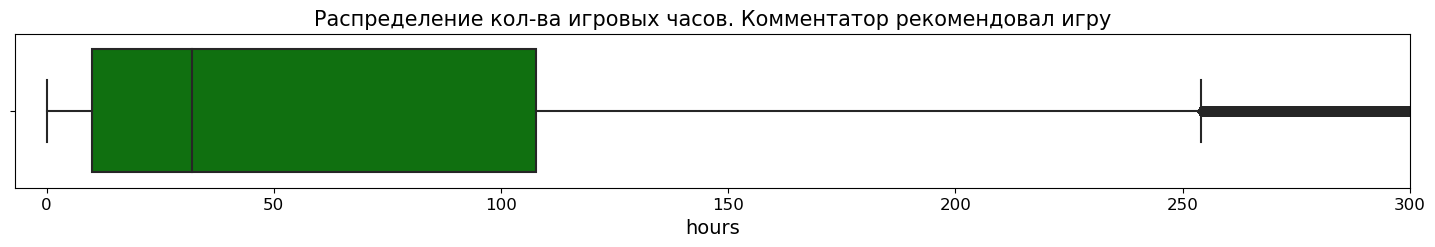

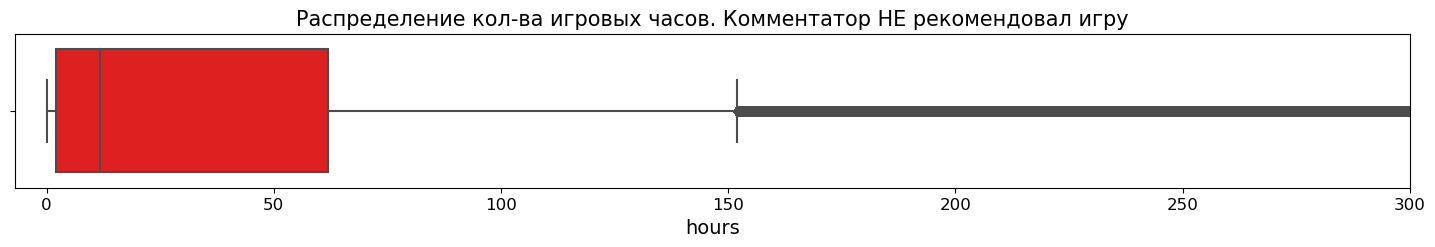

In [16]:
# посмотрим на распределение кол-ва проведенных часов за игрой в разрезе рекомендаций
for is_recommended in (True, False):
    plt.figure(figsize=(18, 2))
    ax = sns.boxplot(x='hours', data=data[data.is_recommended == is_recommended], 
                     color=('red', 'green')[is_recommended]);
    ax.set_xlim(-7, 300)
    plt.title(f'Распределение кол-ва игровых часов. Комментатор {"НЕ " * (not is_recommended)}рекомендовал игру')
    plt.show()

### В медианном значении: те, кто не рекоммендуют игру играют в неё около 12 часов. Если игра затянула то, тот кто её рекомендовал - играл более 32 часов.

In [17]:
# посмотрим на самые популярные жанры игр (отфильтруем игры, у которых игроков менее квартили)
df = df_grp[df_grp['users'] > df_grp['users'].quantile(0.25)].merge(metadata[['app_id', 'tags']], 
                                                                    on='app_id')
df = df.merge(games[['app_id', 'title']], on='app_id')

In [18]:
df.head()

,app_id,is_recommended,hours_mean,hours_median,users,tags,title
0,10,False,108.937500,10.703125,1596,"[Action, FPS, Multiplayer, Shooter, Classic, T...",Counter-Strike
1,10,True,233.625000,110.812500,36006,"[Action, FPS, Multiplayer, Shooter, Classic, T...",Counter-Strike
2,20,False,7.738281,0.700195,565,"[Action, FPS, Multiplayer, Classic, Hero Shoot...",Team Fortress Classic
3,20,True,37.531250,3.400391,3462,"[Action, FPS, Multiplayer, Classic, Hero Shoot...",Team Fortress Classic
4,30,False,11.273438,0.500000,452,"[FPS, World War II, Multiplayer, Shooter, Acti...",Day of Defeat


In [19]:
import gc

data = None
gc.collect()

2977

In [20]:
# TOP-10 игр в которых играло больше всего пользователей
top_users = df.sort_values('users', ascending=False).head(100)
title_users = top_users.head(10)['title'].to_list()
top_users.head(10)

,app_id,is_recommended,hours_mean,hours_median,users,tags,title
33,440,True,306.5000,238.00000,285635,"[Free to Play, Hero Shooter, Multiplayer, FPS,...",Team Fortress 2
3332,252490,True,341.2500,283.00000,217363,"[Survival, Crafting, Multiplayer, Open World, ...",Rust
11321,431960,True,99.6875,36.68750,184884,"[Mature, Utilities, Software, Anime, Design & ...",Wallpaper Engine
43,730,True,404.2500,375.50000,175435,"[FPS, Shooter, Multiplayer, Competitive, Actio...",Counter-Strike: Global Offensive
8844,374320,True,172.2500,125.00000,174085,"[Souls-like, Dark Fantasy, Difficult, RPG, Atm...",DARK SOULS™ III
11794,444090,True,133.5000,56.81250,169876,"[Hero Shooter, Free to Play, Multiplayer, FPS,...",Paladins®
37,550,True,132.0000,50.90625,169261,"[Zombies, Co-op, FPS, Multiplayer, Shooter, On...",Left 4 Dead 2
2560,227300,True,175.0000,99.00000,169212,"[Driving, Transportation, Simulation, Open Wor...",Euro Truck Simulator 2
30507,1091500,True,112.8125,85.62500,167717,"[Cyberpunk, Open World, RPG, Nudity, Singlepla...",Cyberpunk 2077
26993,945360,True,52.0000,33.31250,149608,"[Multiplayer, Online Co-Op, Social Deduction, ...",Among Us


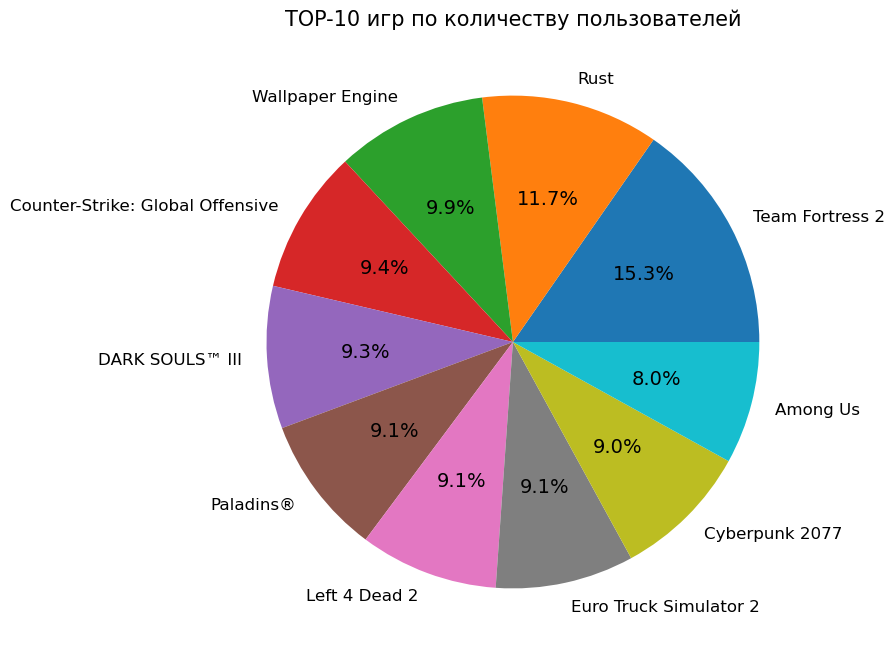

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('TOP-10 игр по количеству пользователей')
ax.pie(top_users.head(10)['users'], labels=top_users.head(10)['title'], autopct='%1.1f%%')
plt.show()

In [22]:
# TOP-10 игр за которыми больше всего провели времени в среднем
top_hours = df.sort_values('hours_mean', ascending=False).head(100)
title_hours = top_hours.head(10)['title'].to_list()
top_hours.head(10)

,app_id,is_recommended,hours_mean,hours_median,users,tags,title
39,570,True,414.75,401.00,112659,"[Free to Play, MOBA, Multiplayer, Strategy, eS...",Dota 2
43,730,True,404.25,375.50,175435,"[FPS, Shooter, Multiplayer, Competitive, Actio...",Counter-Strike: Global Offensive
42,730,False,396.50,368.00,31108,"[FPS, Shooter, Multiplayer, Competitive, Actio...",Counter-Strike: Global Offensive
34678,1283970,True,392.00,356.25,449,"[Design & Illustration, Utilities, Animation &...",YoloMouse
2809,236850,True,385.00,351.25,34740,"[Grand Strategy, Historical, Simulation, Alter...",Europa Universalis IV
10074,401090,True,379.75,299.50,21,"[Animation & Modeling, Game Development, Desig...",MODO indie
28486,1011510,True,376.75,308.25,453,"[Free to Play, Idler, RPG, Clicker, Strategy, ...",Wizard And Minion Idle
1145,39210,True,373.25,327.50,44381,"[MMORPG, RPG, Massively Multiplayer, Fantasy, ...",FINAL FANTASY XIV Online
40020,1593350,True,370.00,335.50,250,"[Time Management, Idler, Roguelite, Clicker, E...",Increlution
32395,1173510,True,367.00,340.00,358,"[Utilities, Early Access, VR, Singleplayer, So...",XSOverlay


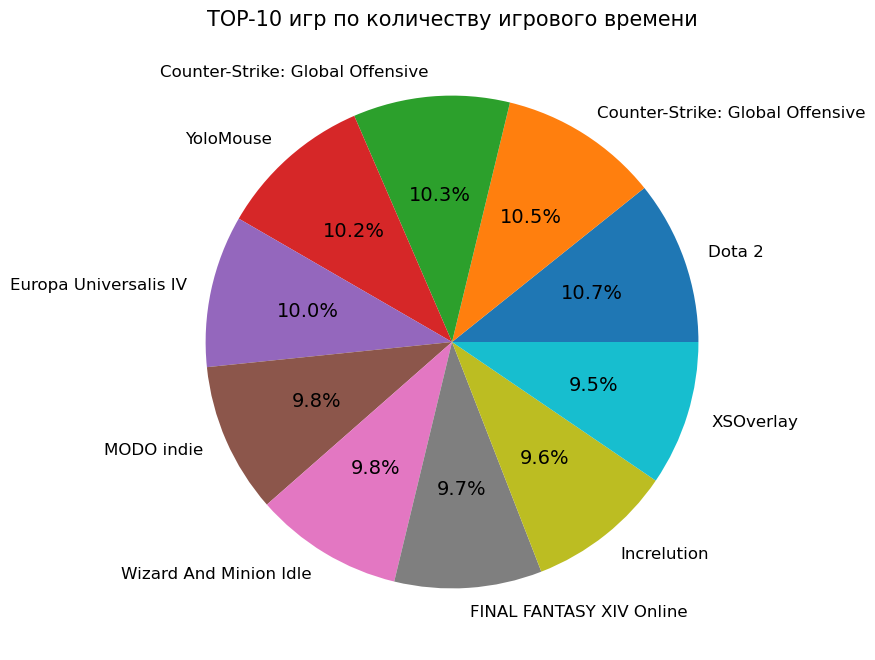

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('TOP-10 игр по количеству игрового времени')
ax.pie(top_hours.head(10)['hours_mean'], labels=top_hours.head(10)['title'], autopct='%1.1f%%')
plt.show()

In [24]:
set(title_users) & set(title_hours)

{'Counter-Strike: Global Offensive'}

### Только одна игра, которая входит в TOP-10 по количеству пользователей и игровых часов

In [25]:
df_tags = df[['app_id', 'is_recommended', 'tags']].explode('tags')
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626718 entries, 0 to 45741
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   app_id          626718 non-null  int64 
 1   is_recommended  626718 non-null  bool  
 2   tags            626718 non-null  object
dtypes: bool(1), int64(1), object(1)
memory usage: 14.9+ MB


In [26]:
# TOP-10 самых популярных жанров
top_tags = df_tags['tags'].value_counts()[:10]
top_tags

Indie           29143
Singleplayer    25005
Action          21267
Adventure       20961
Casual          17952
2D              12062
Simulation      11083
Strategy        10741
Atmospheric     10076
RPG              9893
Name: tags, dtype: int64

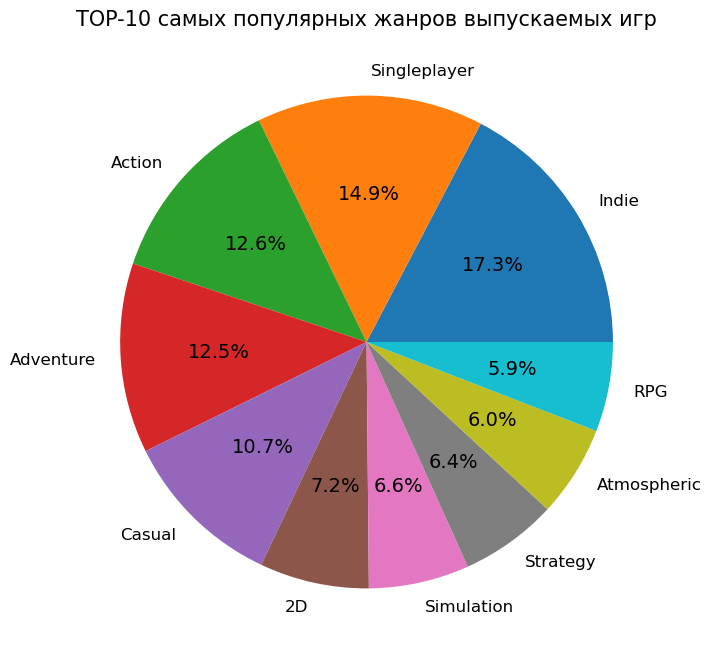

In [27]:
genres = top_tags.keys()
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('TOP-10 самых популярных жанров выпускаемых игр')
ax.pie(top_tags, labels=genres, autopct='%1.1f%%')
plt.show()

In [28]:
df_users = top_users[['app_id', 'is_recommended', 'tags']].explode('tags')
df_hours = top_hours[['app_id', 'is_recommended', 'tags']].explode('tags')
vc_users = pd.DataFrame(df_users['tags'].value_counts()).reset_index()
vc_hours = pd.DataFrame(df_hours['tags'].value_counts()).reset_index()
vc_users.columns = ['tag', 'cnt']
vc_hours.columns = ['tag', 'cnt']
vc_users['kind'] = 'по игрокам'
vc_hours['kind'] = 'по времени'
top_tags = pd.concat([vc_users, vc_hours])
totals = top_tags.groupby('tag', as_index=False).cnt.sum().rename(columns={'cnt': 'total'})
top_tags = top_tags.merge(totals, on='tag', how='left')
top_tags.fillna(0, inplace=True)
top_tags.sort_values(['total'],  ascending=False, inplace=True)

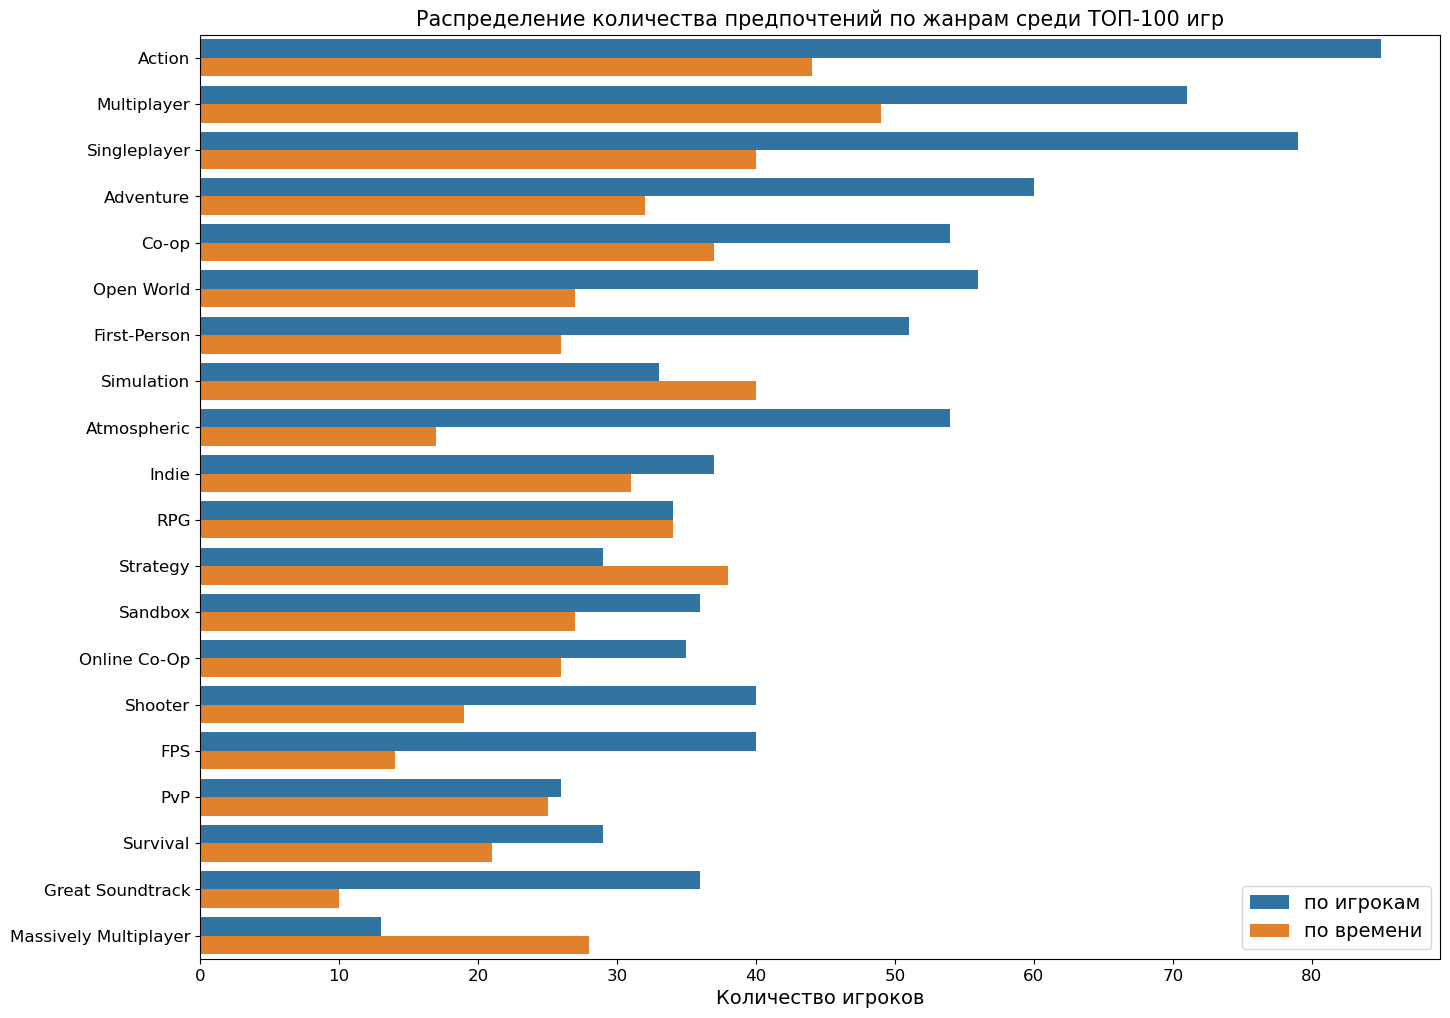

In [29]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.barplot(x='cnt', y='tag', hue='kind', data=top_tags.head(40))
plt.title('Распределение количества предпочтений по жанрам среди ТОП-100 игр')
plt.xlabel('Количество игроков')
plt.ylabel('')
plt.legend(title='')
plt.show()

По данной диаграмме видно, что пользователи в большинстве предпочитают игры с "движухой", но есть пользователи, отдающие свои предочтения играм "мыслительным", на которые тратят больше времени.

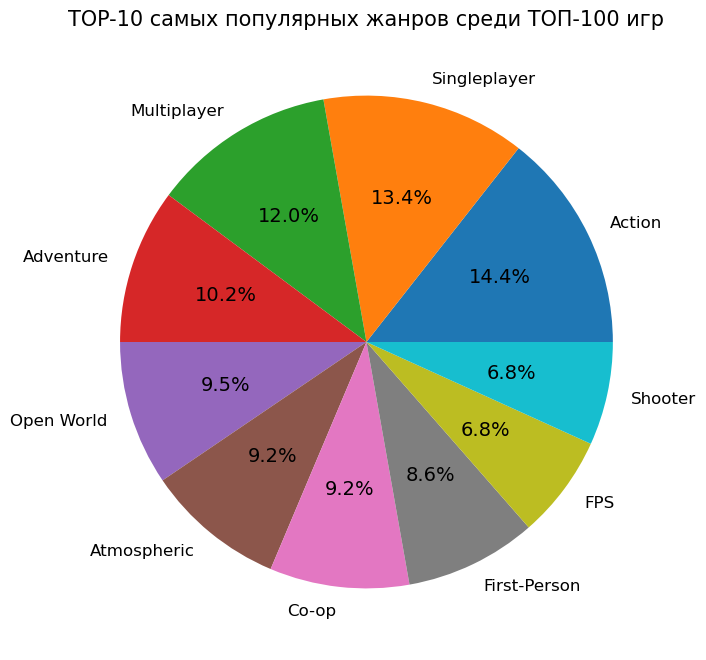

In [30]:
top_10 = df_users['tags'].value_counts()[:10]
gam_10 = top_10.keys()
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('TOP-10 самых популярных жанров среди ТОП-100 игр')
ax.pie(top_10, labels=gam_10, autopct='%1.1f%%')
plt.show()

In [31]:
tops = pd.DataFrame(zip(genres, gam_10), columns=['genre_tags', 'user_tags'], 
                    index=(range(1, len(genres)+1)))
tops

,genre_tags,user_tags
1,Indie,Action
2,Singleplayer,Singleplayer
3,Action,Multiplayer
4,Adventure,Adventure
5,Casual,Open World
6,2D,Atmospheric
7,Simulation,Co-op
8,Strategy,First-Person
9,Atmospheric,FPS
10,RPG,Shooter


In [32]:
set(genres) & set(gam_10)

{'Action', 'Adventure', 'Atmospheric', 'Singleplayer'}

- **genre_tags** - жанры всех выпущенных игр
- **user_tags** - жанры игр из ТОП-100 по количеству игроков

### В двух категориях (genre_tags, user_tags) жанры различаются, всего 4 одинаковых жанра. Возможно производителям игр стоит присмотреться к предпочтениям игроков,